In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sionna
import scipy
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#fc = 8 GHz
#BW = 20 MHz
#lambda/2 antenna spacing
#channel model: ray tracing
#antenna configuration: UPA
#Tx and Rx 50-element antenna array (10 x 5 UPA)

FC = 8e9
BW = 20e6
D_BY_LAMBDA = 0.5
N_TX = 50
N_RX = 50
N_ROWS = 10
N_COLS = 5
PI = np.pi

def find_thresh(arr, N):

    if N <= 0:
        return np.max(arr) + 1
    if N >= arr.size:
        return np.min(arr)
    
    sorted_arr = np.sort(arr)[::-1]
    threshold = sorted_arr[N-1]
    
    return threshold

In [3]:
scene = sionna.rt.load_scene(sionna.rt.scene.etoile)
scene.frequency = FC

In [4]:
scene.tx_array = sionna.rt.PlanarArray(num_rows=N_ROWS,
                             num_cols=N_COLS,
                             vertical_spacing=D_BY_LAMBDA,
                             horizontal_spacing=D_BY_LAMBDA,
                             pattern="tr38901",
                             polarization="V")

scene.rx_array = sionna.rt.PlanarArray(num_rows=N_ROWS,
                             num_cols=N_COLS,
                             vertical_spacing=D_BY_LAMBDA,
                             horizontal_spacing=D_BY_LAMBDA,
                             pattern="tr38901",
                             polarization="V")

TX_LOC = [41,4,19]
# RX_LOC = [-291,-12,15]
RX_LOC = [-291,60, 3]

tx = sionna.rt.Transmitter(name="tx",
                 position=TX_LOC,
                 display_radius=2)

scene.add(tx)

rx = sionna.rt.Receiver(name="rx",
              position=RX_LOC,
              display_radius=2)

scene.add(rx)

tx.look_at(rx)
rx.look_at(tx)

# scene.preview()

Bitmap[
  pixel_format = rgba,
  component_format = uint8,
  size = [655, 500],
  srgb_gamma = 1,
  struct = Struct<4>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
    uint8 A; // @3, normalized, alpha
  ],
  data = [ 1.25 MiB of image data ]
]

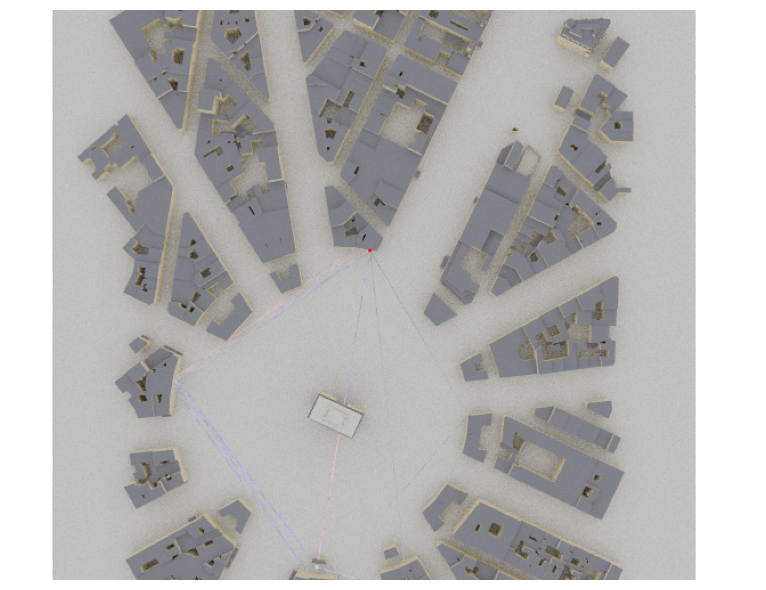

In [5]:
p_solver  = sionna.rt.PathSolver()

# Compute propagation paths
paths = p_solver(scene=scene,
                 max_depth=7,
                 los=True,
                 specular_reflection=True,
                 diffuse_reflection=False,
                 refraction=True,
                 synthetic_array=True,
                 seed=41)

# scene.preview(paths=paths, clip_at=20)
bird_cam = sionna.rt.Camera(position = [-5,-10,950], look_at = [-5,-10,0])
scene.render(camera = bird_cam, paths = paths, num_samples = 64)
scene.render_to_file(camera = bird_cam, filename="p2p_mimo.png", paths = paths, num_samples = 64)

Shape of h_freq:  (1, 50, 1, 50, 1, 1000)


Text(0.5, 1.0, 'Channel Frequency Response')

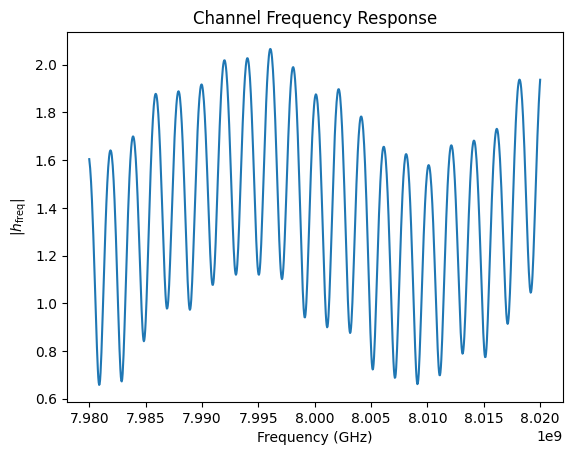

In [6]:
nfreqs = 1000
sweep_freqs = np.linspace(FC-BW, FC+BW, num=nfreqs)
h_freq_sweep = paths.cfr(frequencies=sweep_freqs,
                   normalize=True, # Normalize energy
                   normalize_delays=True,
                   out_type="numpy")

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, num_subcarriers]
print("Shape of h_freq: ", h_freq_sweep.shape)
plt.figure()
plt.plot(sweep_freqs, np.abs(h_freq_sweep)[0,0,0,0,0,:])
plt.xlabel("Frequency (GHz)")
plt.ylabel(r"|$h_\text{freq}$|")
plt.title("Channel Frequency Response")

Shape of h_freq_FC:  (1, 50, 1, 50, 1, 1)
1.9522052


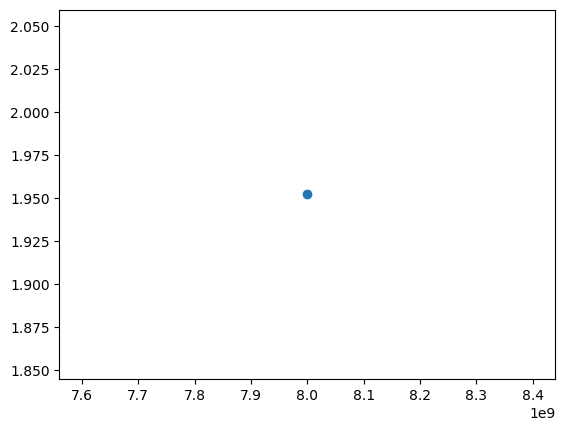

In [7]:
h_freq_FC = paths.cfr(frequencies=FC,
                   normalize=True, # Normalize energy
                   normalize_delays=True,
                   out_type="numpy")

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, num_subcarriers]
print("Shape of h_freq_FC: ", h_freq_FC.shape)
print(np.abs(h_freq_FC)[0,0,0,0,0,0])
plt.scatter(8e9, np.abs(h_freq_FC)[0,0,0,0,0,:])

In [8]:
#h(k,l) => k for tx, l for rx, row is rx, col is tx
h_freq = h_freq_FC.reshape(50,50)
h_freq
U, S, Vh = np.linalg.svd(h_freq)

Shape of a:  (1, 50, 1, 50, 14, 1)
Shape of tau:  (1, 1, 14)


Text(0, 0.5, '$|a|$')

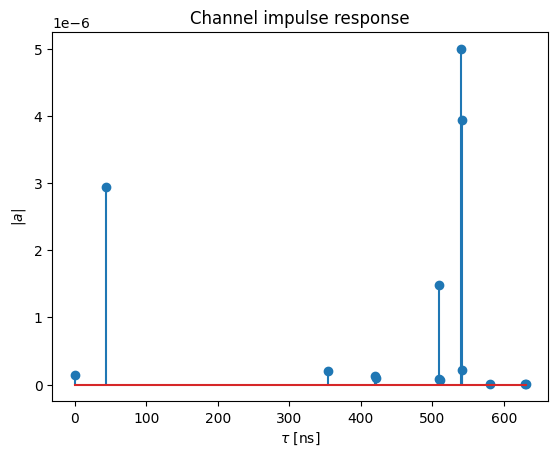

In [9]:
a, tau = paths.cir(normalize_delays=True, out_type="numpy")

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
print("Shape of a: ", a.shape)

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths]
print("Shape of tau: ", tau.shape)

t = tau[0,0,:]/1e-9 # Scale to ns
a_abs = np.abs(a)[0,0,0,0,:,0]
a_max = np.max(a_abs)

# # And plot the CIR
plt.figure()
plt.title("Channel impulse response")
plt.stem(t, a_abs)
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$")

In [10]:
N_PATHS = tau.shape[2]
threshold = find_thresh(S, N_PATHS)
print("threshold: ", threshold)
S_thresh = S[S >= threshold]
rank_h = np.linalg.matrix_rank(h_freq)
rank_h
print(S)
print("numpy rank_h: ", rank_h)
print("my rank_h: ", S_thresh.size)
cond_num = np.linalg.cond(h_freq)
print("condition number: ", cond_num)

threshold:  3.584411e-06
[4.3057522e+01 2.5157961e+01 3.1957369e+00 1.5587471e+00 6.3223636e-01
 2.1751960e-01 1.8202372e-01 4.9459178e-02 2.9302475e-03 1.6128864e-04
 2.9803845e-05 5.4179472e-06 3.9281495e-06 3.5844109e-06 3.0262106e-06
 2.8589282e-06 2.6063121e-06 2.5762217e-06 2.4137305e-06 2.1920225e-06
 2.1004248e-06 2.0394270e-06 1.9100185e-06 1.8626642e-06 1.7220940e-06
 1.6280177e-06 1.5319140e-06 1.4076927e-06 1.3175180e-06 1.2779316e-06
 1.2445380e-06 1.1246480e-06 1.0728510e-06 1.0066329e-06 9.2949989e-07
 8.5896465e-07 7.7185479e-07 7.2544645e-07 6.9913995e-07 6.2177344e-07
 5.7624493e-07 5.2593197e-07 4.6369195e-07 3.8841694e-07 3.6291175e-07
 2.8782532e-07 2.1833011e-07 1.4522620e-07 6.7798254e-08 5.4997752e-08]
numpy rank_h:  9
my rank_h:  14
condition number:  782896000.0


In [11]:
def create_e(n, delta, omega):
    e = np.empty((n,), dtype = np.complex64)
    for i in range(n):
        e[i] = np.exp(-1j*2*PI*delta*omega*i)
    return e * 1 / np.sqrt(n)

def create_U_P2P(n, delta):
    U = []
    for i in range(n):
        U.append(create_e(n, delta, i / (n * delta)))
    return np.array(U)

In [12]:
Ut = create_U_P2P(N_TX, D_BY_LAMBDA)
Ur = create_U_P2P(N_RX, D_BY_LAMBDA)
Ha = Ur.conj().T @ h_freq @ Ut
mag_Ha = np.abs(Ha)
# print(mag_Ha[0])
# print(mag_Ha[3])
# print(mag_Ha[48])
angles_deg = np.arcsin(np.linspace(-1, 1, N_TX)) * 180 /PI

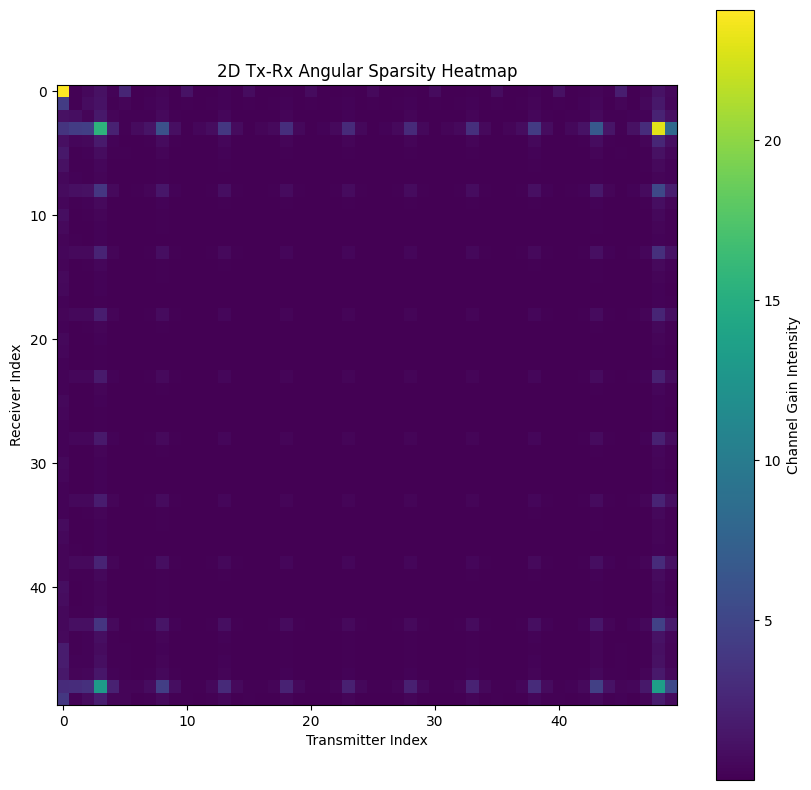

In [13]:
plt.figure(figsize = (10,10))
# plt.imshow(mag_Ha, extent = [angles_deg[0], angles_deg[-1], angles_deg[0], angles_deg[-1]])
plt.imshow(mag_Ha)
plt.xlabel("Transmitter Index") #cols
plt.ylabel("Receiver Index") #rows
plt.title("2D Tx-Rx Angular Sparsity Heatmap")
plt.colorbar(label = "Channel Gain Intensity")

In [14]:
tx_bins_kx = np.arange(Ha.shape[1])
rx_bins_ly = np.arange(Ha.shape[0])
tx_bins_kx, rx_bins_ly = np.meshgrid(tx_bins_kx, rx_bins_ly)

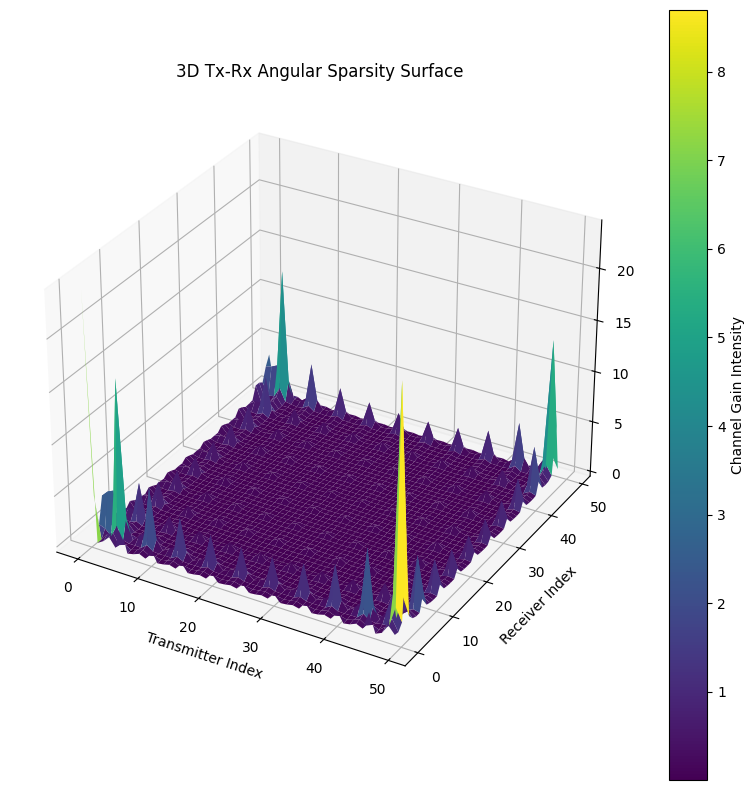

In [15]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection = "3d")
surf = ax.plot_surface(tx_bins_kx, rx_bins_ly, mag_Ha, cmap = "viridis")
ax.set_xlabel("Transmitter Index") #cols
ax.set_ylabel("Receiver Index") #rows
ax.set_title("3D Tx-Rx Angular Sparsity Surface")
fig.colorbar(surf, ax = ax, label = "Channel Gain Intensity")